# Trabajo practico Fundamentos de bases de datos

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Instalacion y importacion de librerias


In [32]:
pip install matplotlib cartopy geopandas

In [12]:
!pip install matplotlib-venn

In [13]:
!apt-get -qq install -y libfluidsynth1

E: Package 'libfluidsynth1' has no installation candidate


In [58]:
import pandas as pd
import numpy as np
from string import ascii_uppercase as alfabeto
import pickle
from bs4 import BeautifulSoup
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import cartopy.crs as ccrs
import statistics
pd.set_option('display.max_columns', None)

In [15]:
csv_file=('/content/drive/MyDrive/TUIA_3er_Cuatrimestre/fundamentos_de_base_de_datos/trabajo_practico/formula1_2020season_raceResults.csv')
df = pd.read_csv(csv_file)
df

,Track,Position,No,Driver,Team,Starting Grid,Laps,Total Time/Gap/Retirement,Points,Fastest Lap
0,Austria,1,77,Valtteri Bottas,Mercedes,1,71,1:30:55.739,25,No
1,Austria,2,16,Charles Leclerc,Ferrari,7,71,+2.700,18,No
2,Austria,3,4,Lando Norris,McLaren Renault,3,71,+5.491,16,Yes
3,Austria,4,44,Lewis Hamilton,Mercedes,5,71,+5.689,12,No
4,Austria,5,55,Carlos Sainz,McLaren Renault,8,71,+8.903,10,No
...,...,...,...,...,...,...,...,...,...,...
335,Abu Dhabi,16,99,Antonio Giovinazzi,Alfa Romeo Racing Ferrari,14,54,+1 lap,0,No
336,Abu Dhabi,17,6,Nicholas Latifi,Williams Mercedes,18,54,+1 lap,0,No
337,Abu Dhabi,18,20,Kevin Magnussen,Haas Ferrari,20,54,+1 lap,0,No
338,Abu Dhabi,19,51,Pietro Fittipaldi,Haas Ferrari,17,53,+2 laps,0,No


### Tipo de Datos Contenidos:

- Track: Categórico - Nombre del circuito.
- Position: Categórico/Numerical - Posición final del piloto (NC para "No Clasificado").
- No: Numérico - Número del piloto.
- Driver: Categórico - Nombre del piloto.
- Team: Categórico - Nombre del equipo.
- Starting Grid: Numérico - Posición de salida.
- Laps: Numérico - Número de vueltas completadas.
- Total Time/Gap/Retirement: Mixto - Tiempo total o diferencia de tiempo respecto al ganador, o estado de retiro (DNF para "Did Not Finish").
- Points: Numérico - Puntos obtenidos en la carrera.
- Fastest Lap: Categórico - Indica si el piloto obtuvo la vuelta más rápida (Yes/No).

### Diccionario de Variables:

- Track: Nombre del circuito donde se corrió la carrera.
- Position: Posición final del piloto al terminar la carrera.
- No: Número del piloto.
- Driver: Nombre del piloto.
- Team: Equipo al que pertenece el piloto.
- Starting Grid: Posición en la parrilla de salida.
- Laps: Número de vueltas completadas.
- Total Time/Gap/Retirement: Tiempo total de carrera, diferencia con el primer puesto, o estado de retiro.
- Points: Puntos obtenidos en la carrera.
- Fastest Lap: Indica si el piloto registró la vuelta más rápida.

### Limpieza del dataset

#### Checkeamos que la posicion numero 20 no salio nunca ya que por lo general en todas las carreras suele haber por lo menos 1 dnf, por lo tanto esta como NC. Entonces tenemos que cambiar los nc por numeros

In [33]:
print(df['Position'].unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [34]:
df['Position'].fillna('NC', inplace=True)

def limpiar_posiciones_nc(df):

    nc_counter = 0
    current_track = None

    new_positions = []

    for idx, row in df.iterrows():
        track = row['Track']
        pos = row['Position']


        if track != current_track:
            current_track = track
            nc_counter = max([int(p) for p in df[df['Track'] == track]['Position'] if p != 'NC'])

        if pos == 'NC':
            nc_counter += 1
            new_positions.append(nc_counter)
        else:
            new_positions.append(int(pos))

    df['Position'] = new_positions
    return df

df_limpio = limpiar_posiciones_nc(df)

print(df_limpio)


         Track  Position  No              Driver                       Team  \
0      Austria         1  77     Valtteri Bottas                   Mercedes   
1      Austria         2  16     Charles Leclerc                    Ferrari   
2      Austria         3   4        Lando Norris            McLaren Renault   
3      Austria         4  44      Lewis Hamilton                   Mercedes   
4      Austria         5  55        Carlos Sainz            McLaren Renault   
..         ...       ...  ..                 ...                        ...   
335  Abu Dhabi        16  99  Antonio Giovinazzi  Alfa Romeo Racing Ferrari   
336  Abu Dhabi        17   6     Nicholas Latifi          Williams Mercedes   
337  Abu Dhabi        18  20     Kevin Magnussen               Haas Ferrari   
338  Abu Dhabi        19  51   Pietro Fittipaldi               Haas Ferrari   
339  Abu Dhabi        20  11        Sergio Perez  Racing Point BWT Mercedes   

     Starting Grid  Laps Total Time/Gap/Retirement 

#### Verificacion de que las posiciones esten bien

In [35]:
if df['Position'].dtype == 'object':
    df['Position'] = df['Position'].str.strip()
    # df['Position'] = pd.to_numeric(df['Position'], errors='coerce')Esto es para pasar a float, pero fue solo una prueba por un error que tiraba

print(df['Position'].unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


#### En el dataset hay pilotos Reemplazantes porque el piloto principal por una razon o otra no pudo asistir a correr por lo tanto yo a los reemplazantes(Corrienron menos de 5 carreras por lo menos) los voy a sacar de mi dataframe

In [36]:
carreras_por_piloto = df['Driver'].value_counts()
pilotos_con_menos_de_5_carreras = carreras_por_piloto[carreras_por_piloto < 5].index

df_filtrado = df[~df['Driver'].isin(pilotos_con_menos_de_5_carreras)]

print("Pilotos eliminados:")
print(pilotos_con_menos_de_5_carreras)

Pilotos eliminados:
Index(['Nico Hulkenberg', 'Pietro Fittipaldi', 'Jack Aitken'], dtype='object', name='Driver')


### Dataset por equipo

In [37]:
data_copia = df_filtrado.copy()
#lista de nombres de variables en columna team
headers_teams=df['Team'].unique()
dicc_df_team = {}
for a in headers_teams:
  data_copia = df_filtrado[df_filtrado['Team'] == a]
  dicc_df_team[a] = data_copia

print(dicc_df_team['McLaren Renault'])

                Track  Position  No        Driver             Team  \
2             Austria         3   4  Lando Norris  McLaren Renault   
4             Austria         5  55  Carlos Sainz  McLaren Renault   
24             Styria         5   4  Lando Norris  McLaren Renault   
28             Styria         9  55  Carlos Sainz  McLaren Renault   
48            Hungary         9  55  Carlos Sainz  McLaren Renault   
52            Hungary        13   4  Lando Norris  McLaren Renault   
64      Great Britain         5   4  Lando Norris  McLaren Renault   
72      Great Britain        13  55  Carlos Sainz  McLaren Renault   
88   70th Anniversary         9   4  Lando Norris  McLaren Renault   
92   70th Anniversary        13  55  Carlos Sainz  McLaren Renault   
105             Spain         6  55  Carlos Sainz  McLaren Renault   
109             Spain        10   4  Lando Norris  McLaren Renault   
126           Belgium         7   4  Lando Norris  McLaren Renault   
139           Belgiu

In [38]:
dicc_victory_team = {}
for team in headers_teams:
        victory_count = df_filtrado[(df_filtrado['Team'] == team) & (df_filtrado['Position'] == 1)].shape[0]
        dicc_victory_team[team] = victory_count

dicc_victory_team_sorted = dict(sorted(dicc_victory_team.items(), key=lambda item: item[1], reverse=True))

print("Cantidad de victorias por equipo (de mayor a menor):")
for team, victories in dicc_victory_team_sorted.items():
    print(f"{team}: {victories}")

Cantidad de victorias por equipo (de mayor a menor):
Mercedes: 13
Red Bull Racing Honda: 2
Racing Point BWT Mercedes: 1
AlphaTauri Honda: 1
Ferrari: 0
McLaren Renault: 0
Renault: 0
Alfa Romeo Racing Ferrari: 0
Williams Mercedes: 0
Haas Ferrari: 0


In [39]:
victorias_por_equipo = df_filtrado[df_filtrado['Position'] == 1]['Team'].value_counts()

print("Equipos ganadores en 2020 y cantidad de victorias:")
print(victorias_por_equipo)

print("\nVerificación de contribución de ambos pilotos:")


for equipo in victorias_por_equipo.index:
    pilotos_en_equipo = df_filtrado[df_filtrado['Team'] == equipo]['Driver'].unique()

    if len(pilotos_en_equipo) >= 2:
        victorias_pilotos = df_filtrado[(df_filtrado['Team'] == equipo) & (df_filtrado['Position'] == 1)]['Driver'].value_counts()

        if len(victorias_pilotos) == 2:
            print(f"En el equipo {equipo} ambos pilotos contribuyeron a las victorias.")
        else:
            print(f"En el equipo {equipo} no todos los pilotos contribuyeron a las victorias.")
    else:
        print(f"El equipo {equipo} tiene menos de dos pilotos registrados en 2020.")

equipo_mas_dominante = victorias_por_equipo.idxmax()
print(f"\nEl equipo más dominante en 2020 fue: {equipo_mas_dominante}")

Equipos ganadores en 2020 y cantidad de victorias:
Team
Mercedes                     13
Red Bull Racing Honda         2
AlphaTauri Honda              1
Racing Point BWT Mercedes     1
Name: count, dtype: int64

Verificación de contribución de ambos pilotos:
En el equipo Mercedes ambos pilotos contribuyeron a las victorias.
En el equipo Red Bull Racing Honda no todos los pilotos contribuyeron a las victorias.
En el equipo AlphaTauri Honda no todos los pilotos contribuyeron a las victorias.
En el equipo Racing Point BWT Mercedes no todos los pilotos contribuyeron a las victorias.

El equipo más dominante en 2020 fue: Mercedes


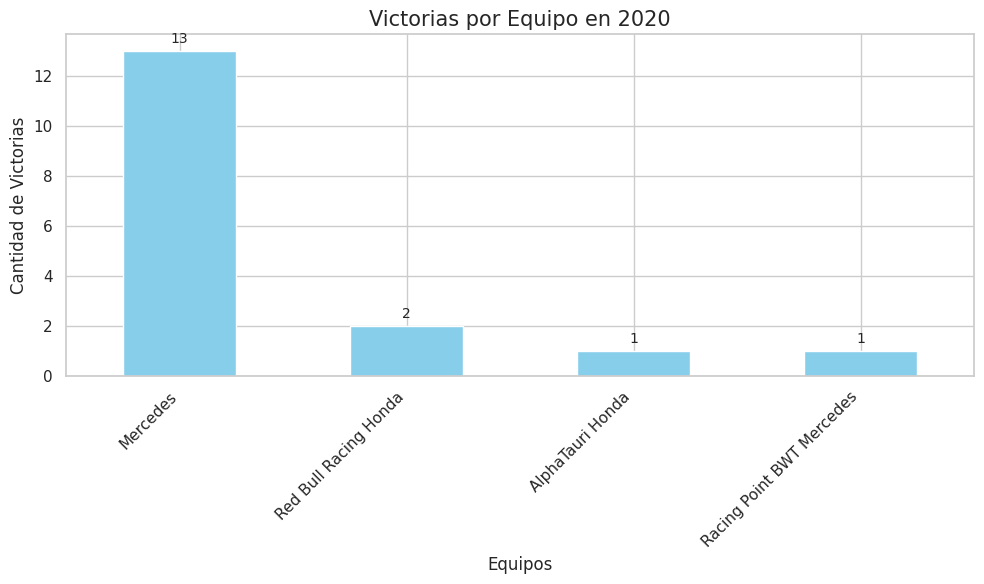

In [53]:
victorias_por_equipo = df_filtrado[df_filtrado['Position'] == 1]['Team'].value_counts()

victorias_por_equipo = victorias_por_equipo.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
victorias_por_equipo.plot(kind='bar', color='skyblue')


plt.title('Victorias por Equipo en 2020', fontsize=15)
plt.xlabel('Equipos', fontsize=12)
plt.ylabel('Cantidad de Victorias', fontsize=12)

for i, v in enumerate(victorias_por_equipo):
    plt.text(i, v + 0.2, str(v), ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Descripción del Gráfico

- Eje Horizontal (X): Representa los equipos que participaron en la temporada.

- Eje Vertical (Y): Muestra la cantidad de victorias obtenidas por cada equipo.

Interpretación
- Este histograma nos permite visualizar y comparar de manera efectiva el número de victorias entre los diferentes equipos.

- Podemos identificar rápidamente cuál equipo obtuvo la mayor cantidad de victorias, así como la diferencia en el número de victorias entre los equipos.

- También podemos observar patrones como equipos con una única victoria frente a equipos con múltiples victorias.

Conclusiones
- La visualización mediante histograma es útil para entender cómo se distribuyeron las victorias entre los equipos durante la temporada.

- Proporciona una representación clara y visual de los datos, permitiendo identificar rápidamente qué equipos dominaron la temporada en términos de victorias.

- En la temporada de Fórmula 1 de 2020, Mercedes fue claramente el equipo más dominante, con 13 victorias, seguido por Red Bull Racing Honda, AlphaTauri Honda y Racing Point BWT Mercedes con 2, 1 y 1 victoria respectivamente.

### Dataset por pilotos
Hay pilotos que solo reemplazaron al piloto principal por algun motivo, por lo tanto si corrieron una sola carrera no los vamos a tener en cuenta

In [54]:
header_drivers=df_filtrado['Driver'].unique()
dicc_df_driver = {}
for a in header_drivers:
  data_copia = df_filtrado[df_filtrado['Driver'] == a]
  dicc_df_driver[a] = data_copia

print(dicc_df_driver)

{'Valtteri Bottas':                 Track  Position  No           Driver      Team  Starting Grid  \
0             Austria         1  77  Valtteri Bottas  Mercedes              1   
21             Styria         2  77  Valtteri Bottas  Mercedes              4   
42            Hungary         3  77  Valtteri Bottas  Mercedes              2   
70      Great Britain        11  77  Valtteri Bottas  Mercedes              2   
82   70th Anniversary         3  77  Valtteri Bottas  Mercedes              1   
102             Spain         3  77  Valtteri Bottas  Mercedes              2   
121           Belgium         2  77  Valtteri Bottas  Mercedes              2   
144             Italy         5  77  Valtteri Bottas  Mercedes              2   
161           Tuscany         2  77  Valtteri Bottas  Mercedes              2   
180            Russia         1  77  Valtteri Bottas  Mercedes              3   
218             Eifel        19  77  Valtteri Bottas  Mercedes              1   
221     

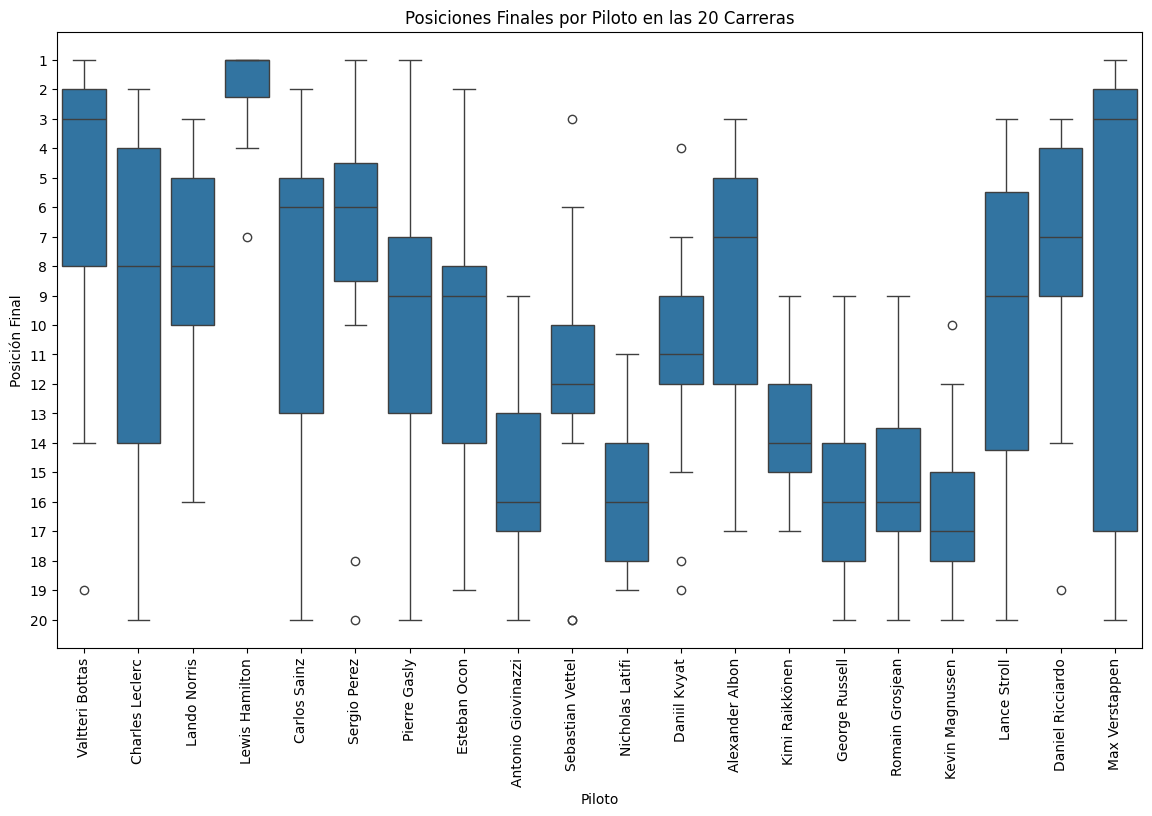

In [42]:

plt.figure(figsize=(14, 8))
sns.boxplot(x='Driver', y='Position', data=df_filtrado)

plt.xticks(rotation=90)

plt.title('Posiciones Finales por Piloto en las 20 Carreras')
plt.xlabel('Piloto')
plt.ylabel('Posición Final')

plt.gca().invert_yaxis()
plt.yticks(range(1, 21))

plt.show()

Descripción del Gráfico
- Eje Horizontal (X): Representa a los 20 pilotos de Fórmula 1.

- Eje Vertical (Y): Muestra la posición final alcanzada por cada piloto en las carreras disputadas durante la temporada.


Consistencia de Lewis Hamilton:

- El boxplot de Lewis Hamilton muestra una distribución concentrada hacia las posiciones más altas en el gráfico.

- Esto indica que Hamilton mantuvo un rendimiento consistente, logrando posiciones de liderazgo en comparación con otros pilotos.

Comparación con Otros Pilotos:

- En contraste, otros pilotos presentan una mayor variabilidad en sus posiciones finales, con algunos mostrando una dispersión más amplia en las posiciones alcanzadas.


### Dataset por circuito

In [29]:
race_tracks=df_filtrado['Track'].unique()

dicc_df_Rtracks = {}
for a in race_tracks:
  data_copia = df_filtrado[df_filtrado['Track'] == a]
  dicc_df_Rtracks[a] = data_copia
print(df_filtrado['Track'].unique()) # TENER EN CUENTA QUE 70th Anniversary fue en inglaterra por lo tanto 2 carreras seguidas se corrieron en el mismo circuito y que eiffel fue en alemania
print(dicc_df_Rtracks['Austria'])

['Austria' 'Styria' 'Hungary' 'Great Britain' '70th Anniversary' 'Spain'
 'Belgium' 'Italy' 'Tuscany' 'Russia' 'Eifel' 'Portugal' 'Emilia Romagna'
 'Turkey' 'Bahrain' 'Sakhir' 'Abu Dhabi']
      Track  Position  No              Driver                       Team  \
0   Austria         1  77     Valtteri Bottas                   Mercedes   
1   Austria         2  16     Charles Leclerc                    Ferrari   
2   Austria         3   4        Lando Norris            McLaren Renault   
3   Austria         4  44      Lewis Hamilton                   Mercedes   
4   Austria         5  55        Carlos Sainz            McLaren Renault   
5   Austria         6  11        Sergio Perez  Racing Point BWT Mercedes   
6   Austria         7  10        Pierre Gasly           AlphaTauri Honda   
7   Austria         8  31        Esteban Ocon                    Renault   
8   Austria         9  99  Antonio Giovinazzi  Alfa Romeo Racing Ferrari   
9   Austria        10   5    Sebastian Vettel      

In [44]:
ubicaciones = {
    'Austria': (47.2195, 14.7644),
    'Styria': (47.2195, 14.7644),  # Misma ubicación que Austria para ejemplo
    'Hungary': (47.49801, 19.03991),
    'Great Britain': (52.0780, -1.0166),
    '70th Anniversary': (52.0780, -1.0166),  # Misma ubicación que Great Britain para ejemplo
    'Spain': (40.4604, -3.6699),
    'Belgium': (50.4372, 5.9714),
    'Italy': (45.5246, 9.2815),
    'Tuscany': (43.7031, 10.3064),
    'Russia': (43.4056, 39.9578),
    'Eifel': (50.3481, 7.5848),
    'Portugal': (39.4629, -8.4681),
    'Emilia Romagna': (44.3439, 11.7167),
    'Turkey': (40.9517, 29.4050),
    'Bahrain': (26.0320, 50.5100),
    'Sakhir': (26.0320, 50.5100),  # Misma ubicación que Bahrain (Se corrio en mismo circuito pero distinto trazado)
    'Abu Dhabi': (24.4672, 54.6034)
}

df_circuitos = pd.DataFrame(list(ubicaciones.items()), columns=['Circuito', 'Ubicacion'])
df_circuitos['Numero Carrera'] = df_circuitos.index + 1
print(df_circuitos)

            Circuito             Ubicacion  Numero Carrera
0            Austria    (47.2195, 14.7644)               1
1             Styria    (47.2195, 14.7644)               2
2            Hungary  (47.49801, 19.03991)               3
3      Great Britain     (52.078, -1.0166)               4
4   70th Anniversary     (52.078, -1.0166)               5
5              Spain    (40.4604, -3.6699)               6
6            Belgium     (50.4372, 5.9714)               7
7              Italy     (45.5246, 9.2815)               8
8            Tuscany    (43.7031, 10.3064)               9
9             Russia    (43.4056, 39.9578)              10
10             Eifel     (50.3481, 7.5848)              11
11          Portugal    (39.4629, -8.4681)              12
12    Emilia Romagna    (44.3439, 11.7167)              13
13            Turkey     (40.9517, 29.405)              14
14           Bahrain       (26.032, 50.51)              15
15            Sakhir       (26.032, 50.51)              

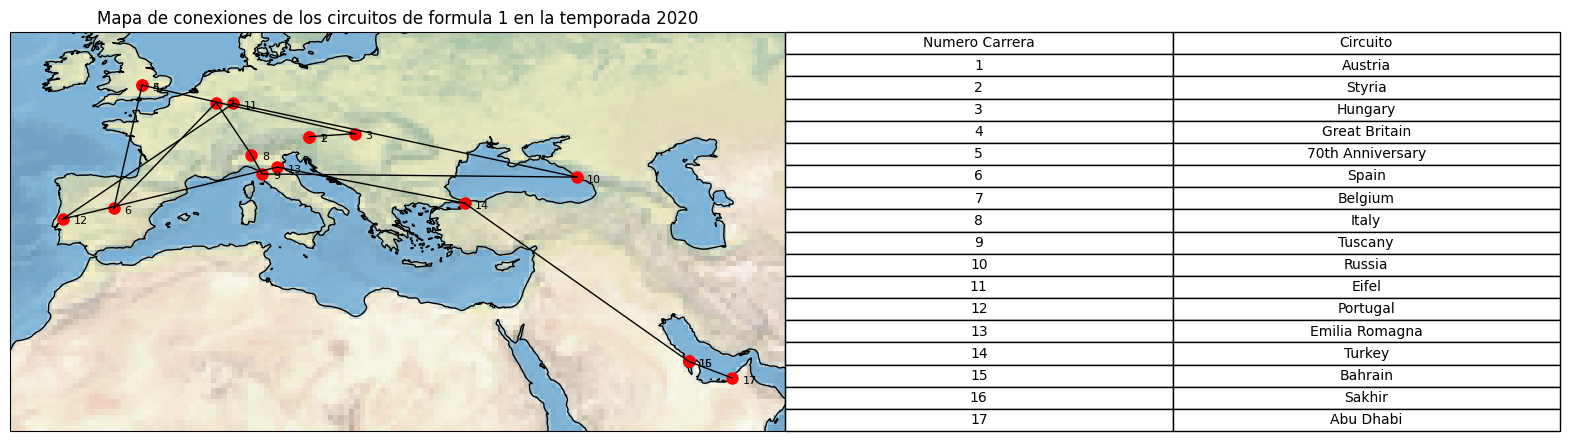

In [45]:
lats = []
lons = []
numeros_carrera = []

for index, (circuito, coords) in enumerate(ubicaciones.items()):
    if isinstance(coords, list):
        for lat, lon in coords:
            lats.append(lat)
            lons.append(lon)
            numeros_carrera.append(index + 1)
    else:
        lat, lon = coords
        lats.append(lat)
        lons.append(lon)
        numeros_carrera.append(index + 1)

min_lat = min(lats) - 5  # Agregar un pequeño margen(CALCULAMOS LAS UBICACIONES MINIMAS Y MAXIMAS Y LE DAMOS MARGEN PARA VISUALIZAR MEJOR TODO)
max_lat = max(lats) + 5
min_lon = min(lons) - 5
max_lon = max(lons) + 5

# Crear la figura y los ejes del mapa con la extensión ajustada
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 8))
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

# Agregar un mapa base
ax.stock_img()

# Dibujar los circuitos como puntos en el mapa solo con número de carrera
for circuito, coords, numero in zip(df_circuitos['Circuito'], ubicaciones.values(), df_circuitos['Numero Carrera']):
    if isinstance(coords, list):
        for lat, lon in coords:
            ax.plot(lon, lat, 'o', color='red', markersize=8, transform=ccrs.PlateCarree())
            ax.text(lon + 1, lat - 0.5, f"{numero}", color='black', fontsize=8, transform=ccrs.PlateCarree())
    else:
        lat, lon = coords
        ax.plot(lon, lat, 'o', color='red', markersize=8, transform=ccrs.PlateCarree())
        ax.text(lon + 1, lat - 0.5, f"{numero}", color='black', fontsize=8, transform=ccrs.PlateCarree())

# Dibujar líneas de conexión entre las ubicaciones de los circuitos
for i in range(len(df_circuitos) - 1):
    lat1, lon1 = df_circuitos['Ubicacion'][i]
    lat2, lon2 = df_circuitos['Ubicacion'][i + 1]
    ax.plot([lon1, lon2], [lat1, lat2], linestyle='-', linewidth=1, color='black', transform=ccrs.PlateCarree())

# Configuración final del mapa
ax.coastlines()
ax.set_title('Mapa de conexiones de los circuitos de formula 1 en la temporada 2020')

# Crear tabla de referencia
tabla_referencia = pd.DataFrame(df_circuitos[['Numero Carrera', 'Circuito']])

plt.table(cellText=tabla_referencia.values, colLabels=tabla_referencia.columns, cellLoc='center', loc='bottom', bbox=[1, 0, 1, 1])

plt.show()

### Circuitos por dnf

In [46]:
dicc_dnf_Rtracks = {}
for a in race_tracks:
    if 'Total Time/Gap/Retirement' in df_filtrado.columns:
        dnf_count = df_filtrado[(df_filtrado['Track'] == a) & (df_filtrado['Total Time/Gap/Retirement'] == 'DNF')].shape[0]
        dicc_dnf_Rtracks[a] = dnf_count
    else:
        print(f"La columna 'Total Time/Gap/Retirement' no existe en el DataFrame.")

dicc_dnf_Rtracks_sorted = dict(sorted(dicc_dnf_Rtracks.items(), key=lambda item: item[1], reverse=True))

print(dicc_dnf_Rtracks_sorted)


{'Austria': 9, 'Tuscany': 8, 'Eifel': 5, 'Emilia Romagna': 5, 'Italy': 4, 'Turkey': 4, 'Styria': 3, 'Bahrain': 3, 'Sakhir': 3, 'Great Britain': 2, 'Belgium': 2, 'Russia': 2, 'Hungary': 1, '70th Anniversary': 1, 'Spain': 1, 'Portugal': 1, 'Abu Dhabi': 1}


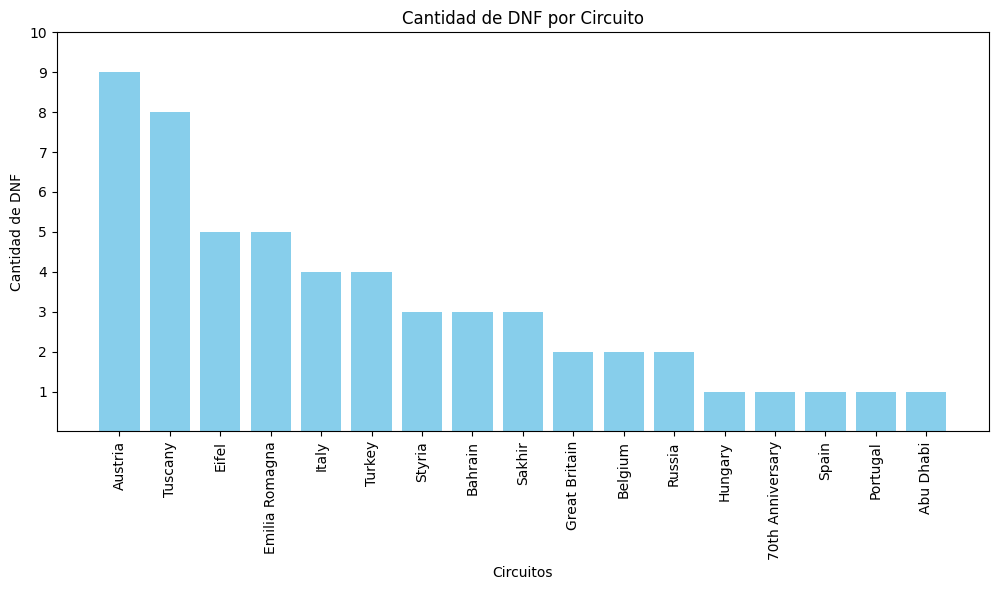

In [47]:
circuitos = list(dicc_dnf_Rtracks_sorted.keys())
dnf_counts = list(dicc_dnf_Rtracks_sorted.values())

plt.figure(figsize=(10, 6))
plt.bar(circuitos, dnf_counts, color='skyblue')
plt.xlabel('Circuitos')
plt.ylabel('Cantidad de DNF')
plt.title('Cantidad de DNF por Circuito')
plt.xticks(rotation=90)
plt.tight_layout()
plt.yticks(range(1, 11))

plt.show()

Descripción del Gráfico
- Eje Horizontal (X): Representa los circuitos de la temporada.

- Eje Vertical (Y): Muestra la cantidad de DNF registrados en cada circuito, indicado por la altura de las barras.


Causas Potenciales de Abandonos:

- Accidentes Múltiples: Lugares con alta concentración de DNF podrían haber sido escenarios de colisiones que involucraron a múltiples autos al mismo tiempo.

- Condiciones Climáticas: La presencia de DNF podría relacionarse con condiciones climáticas desafiantes, como lluvia intensa que afecta la visibilidad y la adherencia de los neumáticos.

- Características del Circuito: Los circuitos callejeros, con sus curvas estrechas y menor adherencia, pueden haber contribuido significativamente a los abandonos registrados.


Conclusiones
- Este gráfico de barras es una herramienta efectiva para evaluar la seguridad y el desempeño de los pilotos en diferentes circuitos.

- Permite identificar patrones y tendencias que pueden influir en el resultado de las carreras y en el campeonato en general.

- Analizando las circunstancias detrás de los DNF, podemos mejorar la preparación y la estrategia para futuras temporadas, priorizando la seguridad y la competitividad de los eventos.


### Promedio de puntos por piloto

In [48]:
dicc_df_driver
header_drivers
dicc_sum_puntos = {}
for driver in header_drivers:
  data_copia = df_filtrado[df_filtrado['Driver'] == driver]
  dicc_sum_puntos[driver] = sum(data_copia['Points'])

dicc_sum_puntos_sorted = dict(sorted(dicc_sum_puntos.items(), key=lambda item: item[1], reverse=True))
print(dicc_sum_puntos_sorted)

puntos = list(dicc_sum_puntos_sorted.values())

media_puntos = statistics.mean(puntos)
mediana_puntos = statistics.median(puntos)
desviacion_estandar_puntos = statistics.stdev(puntos)
varianza_puntos = statistics.variance(puntos)
minimo_puntos = min(puntos)
maximo_puntos = max(puntos)

print(f"Media: {media_puntos}")
print(f"Mediana: {mediana_puntos}")
print(f"Desviación Estándar: {desviacion_estandar_puntos}")
print(f"Varianza: {varianza_puntos}")
print(f"Mínimo: {minimo_puntos}")
print(f"Máximo: {maximo_puntos}")

{'Lewis Hamilton': 347, 'Valtteri Bottas': 223, 'Max Verstappen': 214, 'Sergio Perez': 125, 'Daniel Ricciardo': 119, 'Carlos Sainz': 105, 'Alexander Albon': 105, 'Charles Leclerc': 98, 'Lando Norris': 97, 'Pierre Gasly': 75, 'Lance Stroll': 75, 'Esteban Ocon': 62, 'Sebastian Vettel': 33, 'Daniil Kvyat': 32, 'Antonio Giovinazzi': 4, 'Kimi Raikkönen': 4, 'George Russell': 3, 'Romain Grosjean': 2, 'Kevin Magnussen': 1, 'Nicholas Latifi': 0}
Media: 86.2
Mediana: 75.0
Desviación Estándar: 90.44544735567635
Varianza: 8180.378947368421
Mínimo: 0
Máximo: 347


### Graficos sobre los promedios de puntos y las diferencias entre los 20 pilotos

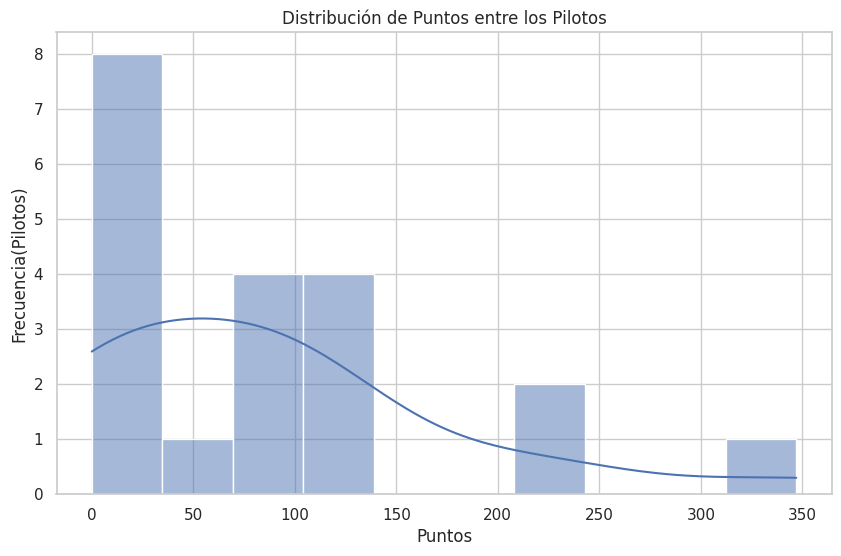

In [51]:
# Convertir los datos a una lista de tuplas para gráficos
conductores = list(dicc_sum_puntos_sorted.keys())
puntos = list(dicc_sum_puntos_sorted.values())

# Configuración de estilo
sns.set(style="whitegrid")

# Histograma
plt.figure(figsize=(10, 6))
sns.histplot(puntos, bins=10, kde=True)
plt.title('Distribución de Puntos entre los Pilotos')
plt.xlabel('Puntos')
plt.ylabel('Frecuencia(Pilotos)')
plt.show()


Descripción del Histograma
- Eje Horizontal (X): Representa los puntos acumulados por los pilotos.

- Eje Vertical (Y): Muestra la frecuencia con la que se observa cada rango de puntos, es decir, cuántos pilotos tienen una cantidad específica de puntos.


Interpretación
- Este histograma nos permite comparar visualmente cómo se distribuyen los puntos entre los pilotos. Podemos identificar rápidamente si hay un grupo de pilotos con puntajes altos, una dispersión amplia de puntajes o cualquier patrón distintivo en la distribución de puntos.

Conclusiones
- La visualización mediante histograma es útil para entender la variabilidad en los resultados de los pilotos en términos de puntos acumulados.

- Nos proporciona una representación clara de la distribución de los datos, permitiendo identificar tendencias y patrones que pueden influir en las posiciones finales del campeonato de pilotos.

<ipython-input-50-27b6aa186a78>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conductores, y=puntos, palette="viridis")


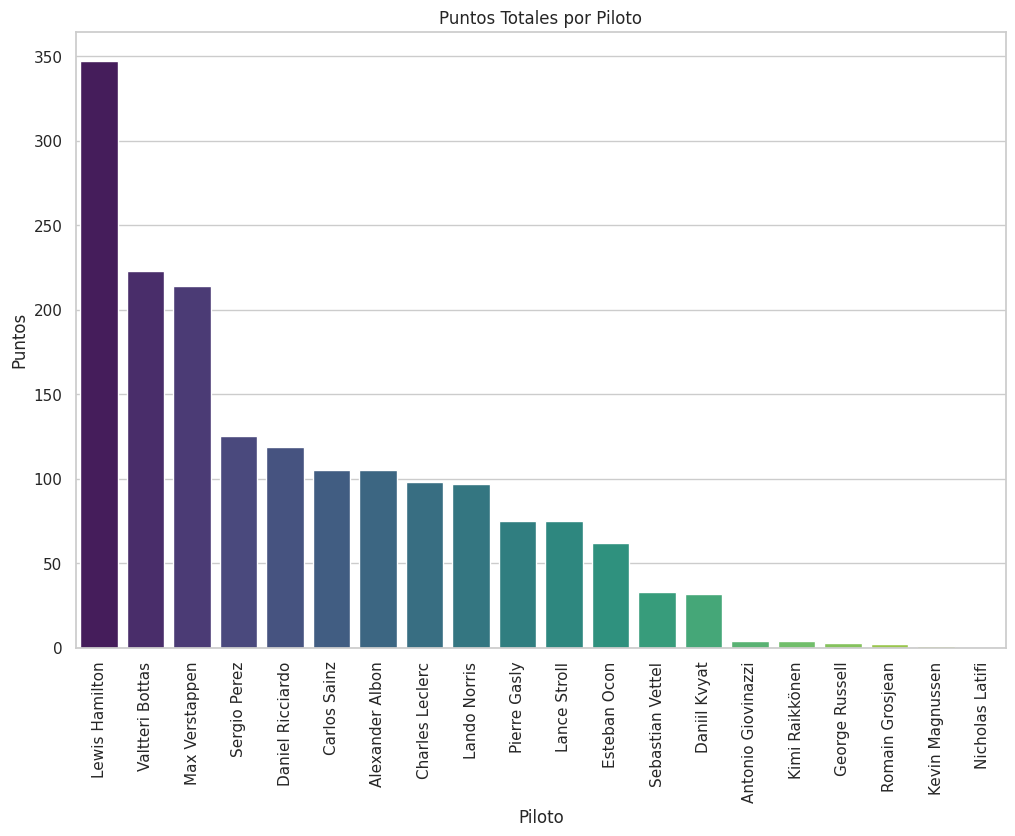

In [50]:
# Gráfico de barras
plt.figure(figsize=(12, 8))
sns.barplot(x=conductores, y=puntos, palette="viridis")
plt.xticks(rotation=90)
plt.title('Puntos Totales por Piloto')
plt.xlabel('Piloto')
plt.ylabel('Puntos')
plt.show()

Descripción del Gráfico
- Eje Vertical (Y): Muestra la cantidad total de puntos acumulados por cada piloto a lo largo de la temporada.

- Eje Horizontal (X): Representa a los pilotos, ordenados según sus posiciones finales en el campeonato.

Análisis de Posiciones Finales:

- Los pilotos que se encuentran en las primeras posiciones del gráfico son aquellos que acumularon la mayor cantidad de puntos, indicando un desempeño consistentemente alto a lo largo de la temporada.

- Los pilotos ubicados en las ultimas posiciones del gráfico acumularon menos puntos, reflejando un desempeño menos consistente o menos competitivo.

Comparación de Desempeños:

- El gráfico permite comparar fácilmente el rendimiento de los pilotos, destacando a aquellos que dominaron la temporada y aquellos que tuvieron dificultades para acumular puntos.

- Es evidente que los pilotos en las primeras posiciones del gráfico no solo obtuvieron buenos resultados en algunas carreras, sino que mantuvieron un alto nivel de rendimiento en la mayoría de las competiciones.

### Análisis de Relación entre Posición de Salida y Posición Final

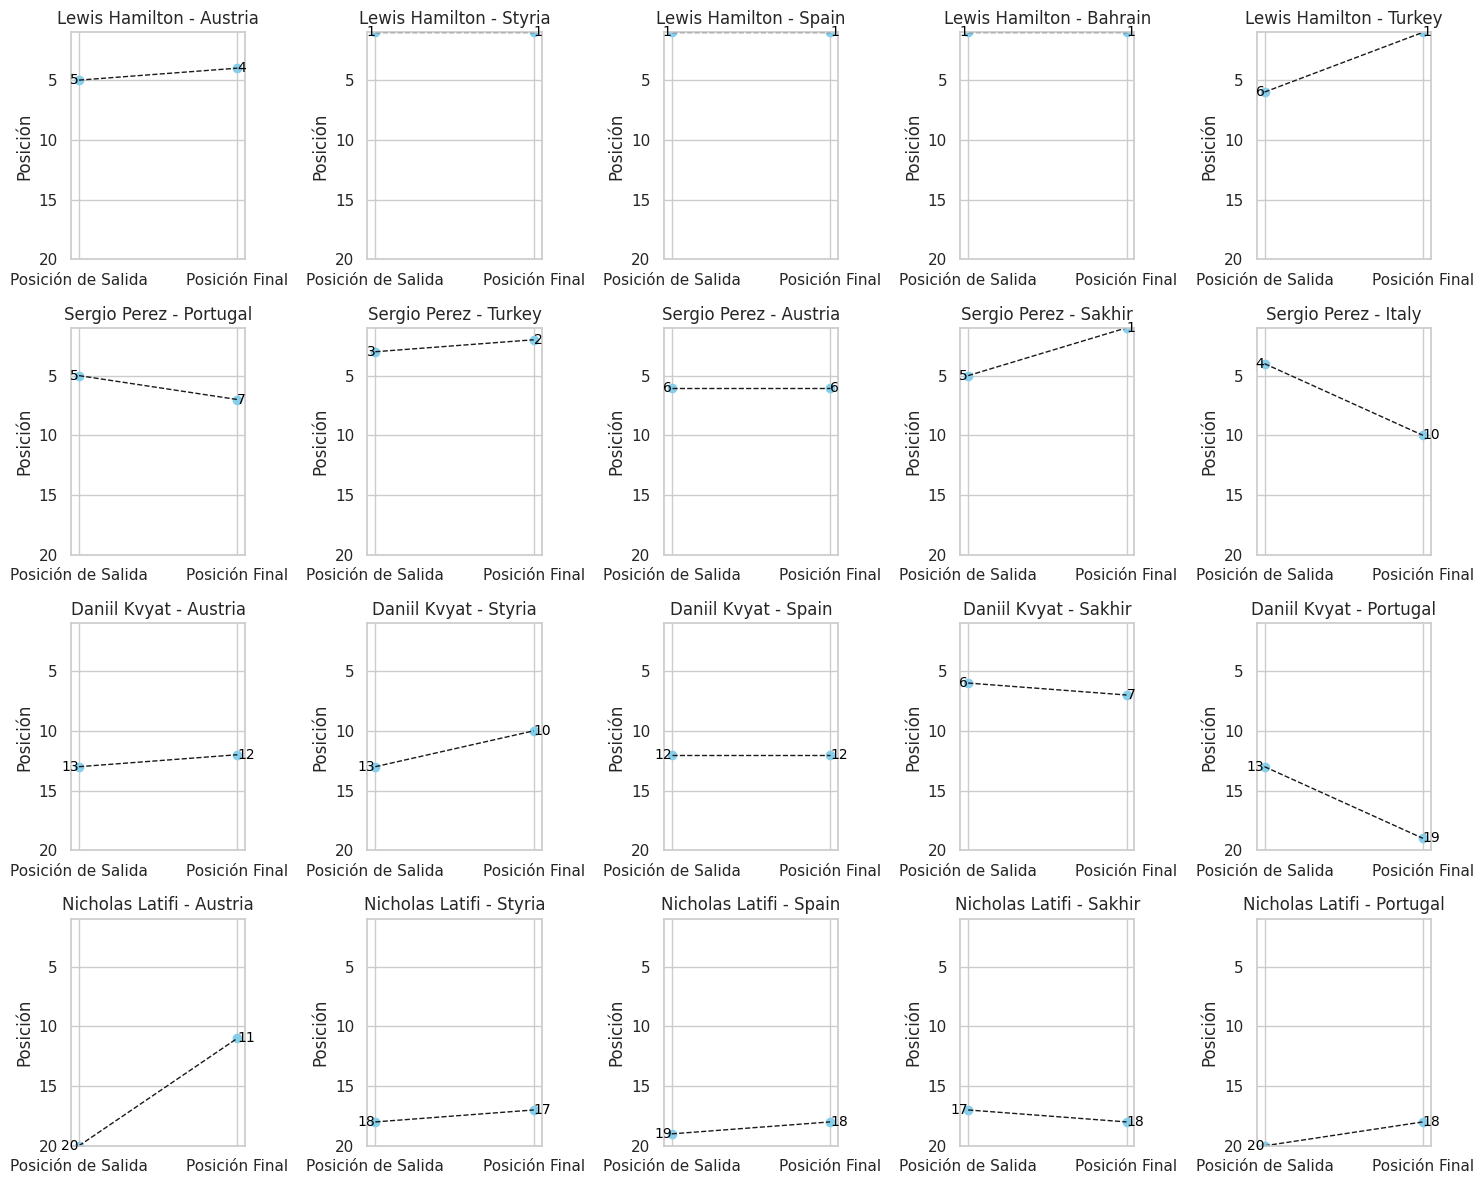

In [68]:
# Pilotos seleccionados
pilotos = ['Lewis Hamilton', 'Sergio Perez', 'Daniil Kvyat', 'Nicholas Latifi']

# Número de circuitos a seleccionar para cada piloto
num_circuitos = 5

# Configurar el tamaño del gráfico
plt.figure(figsize=(15, 12))

# Iterar sobre cada piloto
for i, piloto in enumerate(pilotos, start=1):
    # Obtener datos del piloto
    data_piloto = dicc_df_driver[piloto]

    # Seleccionar aleatoriamente num_circuitos circuitos para mostrar
    circuitos_seleccionados = data_piloto['Track'].sample(num_circuitos, random_state=42)

    # Iterar sobre los circuitos seleccionados
    for j, circuito in enumerate(circuitos_seleccionados, start=1):
        # Filtrar datos por circuito
        data_circuito = data_piloto[data_piloto['Track'] == circuito]

        # Configurar los valores para el scatterplot
        x_values = ['Posición de Salida', 'Posición Final']
        y_values = [data_circuito['Starting Grid'].values[0], data_circuito['Position'].values[0]]

        # Graficar scatterplot para el circuito actual
        plt.subplot(len(pilotos), num_circuitos, (i-1)*num_circuitos + j)
        plt.scatter(x_values, y_values, label=circuito, marker='o', color='skyblue')

        # Añadir líneas de referencia para posición de salida y posición final
        plt.plot(x_values, y_values, 'k--', lw=1)

        # Añadir etiquetas con los valores de posición al lado de los puntos
        for x, y, label in zip(x_values, y_values, ['Salida', 'Llegada']):
            plt.text(x, y, f'{y}', ha='right' if label == 'Salida' else 'left', va='center', fontsize=10, color='black')

        # Añadir etiquetas y título
        plt.title(f'{piloto} - {circuito}')
        plt.ylabel('Posición')
        plt.ylim(1, 20)  # Rango del eje y del 1 al 20
        plt.gca().invert_yaxis()  # Invertir eje y para que la posición 1 sea arriba
        plt.grid(True)
        plt.tight_layout()

# Ajustar espaciado y mostrar gráfico
plt.tight_layout()
plt.show()

Descripción del Gráfico

- Eje Vertical (Y): Representa la posición del piloto en el circuito, donde el número más bajo indica una mejor posición (más cerca del primer lugar).

- Eje Horizontal (X): Muestra dos categorías distintas:

  1. Posición de Salida: Indica en qué posición comenzó el piloto en la parrilla al inicio de la carrera.

  2. Posición Final: Representa en qué posición terminó el piloto al finalizar la carrera.

Interpretación del Gráfico:

- Este gráfico permite comparar visualmente la habilidad de los pilotos para mejorar sus posiciones desde la salida hasta la llegada en diferentes circuitos. Un piloto que logra mantener o mejorar consistentemente su posición desde la salida hasta la llegada puede ser interpretado como más eficiente en las carreras.

- Se pueden identificar patrones y tendencias en el rendimiento de cada piloto en diferentes circuitos. Por ejemplo, algunos pilotos pueden tener un desempeño más fuerte en ciertos tipos de circuitos basados en cómo manejan la posición de salida y las estrategias durante la carrera.

- Es crucial tener en cuenta que el rendimiento de un piloto no solo depende de su habilidad individual, sino también de la estrategia del equipo y las características del auto. La estrategia de pits, la gestión de neumáticos y la configuración del auto pueden ser determinantes significativos en cómo un piloto gestiona sus posiciones desde la salida hasta la llegada.

- Por lo tanto, mientras que la habilidad del piloto juega un papel fundamental, el éxito en las carreras también está influenciado por la colaboración efectiva entre el piloto y su equipo técnico, así como por la adaptabilidad del auto a las condiciones específicas de cada circuito.

Conclusión General del Trabajo Práctico:

Al revisar y analizar el dataset utilizado en este trabajo práctico, se destaca la importancia de prestar atención detallada a los datos con los que se trabaja. En particular, la temporada analizada fue notablemente dominada por Mercedes, lo que puede implicar que algunos aspectos del análisis muestren menos variación en comparación con otras temporadas más competitivas.

Sin embargo, es crucial reconocer que aunque la parte alta de la tabla estuvo dominada por un equipo, las posiciones intermedias mostraron una significativa variabilidad. Equipos de Fórmula 1 diferentes compitieron activamente por estas posiciones, reflejando una competencia más equilibrada y disputada.

Mirando hacia el futuro, este análisis subraya la necesidad de adaptarse a los cambios en el panorama competitivo de la Fórmula 1. Esto implica no solo seguir de cerca el rendimiento de los equipos dominantes, como Red Bull y Mercedes, sino también monitorear cómo otros equipos responden y se adaptan a los desafíos de cada temporada.

## Limpieza + creacion de datasets
- separar dataset por equipos
- separar dataset por pilotos
- separar dataset por circuito

## Ideas de data

- Probabilidad del equipo de que gane
- probabilidad de cada piloto del equipo que gane

- porcentaje de victoria por equipo
- porcentaje de victoria por piloto

- cantidad de puntos por temporada
- cantidad de dnf
- Puntos de cada piloto despues de cada carrera


- cantidad de victorias por equipo
- cantidad de victorias por piloto

- Analisis por equipos

- analisis de circuitos que tiendan mas a que haya dnf, por lo general los callejeros

- piloto con mas 1,2,3...20, puesto.

- Pilotos que ganaron
- pilotos que no ganaron

- distribucion de victorias por equipo

- Podemos tambien hacer algun tipo de analisis de carreras por pais/continente y que hay varias carreras en italia, usa en el caso de paises y de continente en europa se corre en españa, italia, gran bretaña.

porcentajes de clasificacion en la grilla si llego a q1(16-20) q2(11-15) q3(top 10)

## Graficos
grafico barra de
grafico torta de
Box plots de

## Problemas del dataset
El tiempo total de carrera esta hecho en
hh mm ss

El fastest lap es boleano por lo tanto habria que ver de hacer alguna funcion o ver de sumar la cantidad total de vueltas rapidas del año de cada piloto

## Preguntas

Podemos preguntar cuales son los impactos negativos de que un piloto tenga muchos dnf o termine siempre muy ultimo

preguntar que pilotos pueden quedar afuera al otro año segun sus resultados

recorrido/transporte de todo el equipamiento y demas entre una carrera y la otra

mirar :
https://www.data-to-viz.com/

comparar victorias por equipo
por ejemplo con la cantidad de victorias por equipo podemos ver la dominancia de un equipo en particular en ese año

Pregunta 1: Que equipos ganaron y cual tuvo mayor dominancia en el año 2020. En
el caso ver si en el equipo ganaron los 2 pilotos.  
## Hecho el diccionario con las victorias

Pregunta 2: Que circuitos tuvo mayor dnf, y si hay algo en comun, por ej los circuitos callejeros suelen tener mas accidentes porque el material del suelo tiene menos adherencia que un circuito especifico de carrera. grafico bastones
## HECHO EL DICCIONARIO

Pregunta 3: Diferencias de los puestos en los que terminaron por piloto para hacer un boxplot en las 20 carreras
# HECHO EL GRAFICO


Pregunta 4: Relación entre posición de salida y posición final: Análisis de correlación entre la posición en la parrilla y la posición final. Cuantos sobrepasos hay en cada circuito? para comparar la cantidad de sobrepasos en cada circuito ya que en algunos es mas facil que en otro  
Aca podemos hablar sobre que pilotos que clasifican varias veces dentro del top por lo general es porque tienen buen auto, y los que muy pocas veces arrancan en buenas posiciones y terminan en malas es porque fue una buena vuelta pero no tiene un buen auto/consistencia en carrera
hacer grafico cruzado por piloto y por carrera

x inicio y llegada
y 1-20



Pregunta 5: Comparación de puntos: Calcular el promedio y la desviación estándar de puntos por piloto.
# la 5 esta en duda porque hubo nuchas victorias de los mismos pilotos




# ENUNCIADO

Trabajo Práctico - Fundamentos 2024
Descripción general
El objetivo de este Trabajo Práctico es que los estudiantes adquieran habilidades en la manipulación, limpieza y análisis exploratorio de datos utilizando Python.

En grupos de a 2 (dos) estudiantes, deberán seleccionar un dataset de su interés (ver posibles fuentes más abajo) y, luego de realizar cualquier tarea de limpieza, transformación y adecuación que consideren necesaria, llevar adelante un análisis exploratorio, incluyendo el cálculo e interpretación de medidas descriptivas y la elaboración de herramientas gráficas de visualización.

Detalles de trabajo
Selección del dataset
Cada grupo deberá seleccionar un dataset de una temática que resulte de interés para los integrantes. Para sacar el máximo provecho de las herramientas del análisis exploratorio abordadas durante el curso, se valorará que el dataset seleccionado este compuesto por al menos 6 variables con datos de diferente naturaleza (numéricos, categóricos, geográficos, etc.).

IMPORTANTE. El dataset elegido no deberá provenir de un repositorio en el que se expongan, además, herramientas para su análisis (por ejemplo, Kaggle).

Algunas fuentes sugeridas:

Datos Abiertos de Argentina (https://www.datos.gob.ar)
Datos Abiertos del Ministerio de Salud (http://datos.salud.gob.ar/)
Datos Abiertos Ciudad de Buenos Aires (https://data.buenosaires.gob.ar/dataset/)
Datos de la NASA sobre la Tierra (https://www.earthdata.nasa.gov/)
Datos de Agencias Federales de los EE. UU., incluyendo tópicos como atención médica, energía, transporte y educación, entre otros (https://catalog.data.gov/dataset)
FiveThirtyEight (https://data.fivethirtyeight.com/)
Datos Abiertos del Banco Mundial (https://datos.bancomundial.org/)
Datos Abiertos de UNICEF (https://data.unicef.org/)
Datos de Investigación de CONICET (https://datosdeinvestigacion.conicet.gov.ar/)
Descripción del dataset elegido
Se deberá proporcionar una breve descripción del dataset, incluyendo su origen, tipo de datos que contiene y un diccionario de variables que especifique la información que se encuentra en cada columna.

Manipulación y transformación del dataset
Realizar cualquier tarea de limpieza, transformación y adecuación del dataset que se considere necesaria para su posterior análisis, incluyendo, si corresponde, manejo de datos faltantes, duplicados y/o inconsistentes y modificación de nombres de variables y/o estructura de los datos. Cada una de las acciones que se realicen sobre el dataset deberá estar documentada y debidamente justificada.

Análisis exploratorio de los datos
Realizar un análisis exploratorio de los datos, extrayendo cualquier tipo de información que el grupo juzgue de interés según la temática elegida. El mismo deberá incluir el cálculo de las medidas descriptivas que se consideren adecuadas de acuerdo a las características de las variables, así como la construcción de diferentes herramientas de visualización, las cuales deberán estar debidamente interpretadas y comentadas.

Se valorará positivamente la presentación de diferentes tipos de gráficos, así como el correcto uso de etiquetas de ejes, paletas de colores, leyendas, etc.

Sobre la entrega
Cada grupo deberá entregar un archivo .zip o .rar que contenga:
Archivo/s de datos utilizado/s.
Notebook (.ipynb) con el informe del trabajo realizado.
El nombre del archivo comprimido entregado deberá incluir el detalle de la comisión y los apellidos de los integrantes del grupo en orden alfabético:

C1_DellaCeca_Geary.rar

C2_Anselmino_Ferreyra.zip

Sobre el informe a entregar:
El informe debe contener una descripción clara y concisa de cada una de las etapas mencionadas en la sección Detalles de trabajo, así como el código de Python utilizado, el cual deberá correr sin errores y estar correctamente documentado y estructurado.
Las distintas secciones deberán estar organizadas de una manera prolija, utilizando títulos y subtítulos, y todos los comentarios, interpretaciones y elaboraciones que se realicen a partir de los resultados del análisis deberán incluirse como celdas de texto en lenguaje Markdown.
La entrega se realizará vía Campus en un espacio destinado para tal fin. Sólo uno de los integrantes del grupo deberá hacer la carga del archivo.
FECHAS DE ENTREGA:
Comisión C22: Semana del 20 de mayo (tentativamente el miércoles 22 de mayo)

Medidas Descriptivas:

- Distribución de posiciones finales: Contar y graficar cuántas veces cada piloto ha terminado en diferentes posiciones.
- Comparación de puntos: Calcular el promedio y la desviación estándar de puntos por piloto.
- Relación entre posición de salida y posición final: Análisis de correlación entre la posición en la parrilla y la posición final.

Visualizaciones Propuestas:

- Histograma de posiciones finales: Mostrar la distribución de las posiciones finales de los pilotos por puntos.
- Gráfico de barras de puntos por piloto: Comparar la cantidad de puntos obtenidos por diferentes pilotos.
- Gráfico de dispersión: Visualizar la relación entre la posición de salida y la posición final.